## ULMFiT

Papiers associés:
- [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/abs/1708.02182)
- [Universal Language Model Fine-tuning for Text Classification](https://arxiv.org/abs/1801.06146)


In [1]:
import sys
sys.path.append("../fastai/")
from fastai.text import *
import html

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('data/')

## Données

In [3]:
dataset = pd.read_csv(PATH/'train_cap2018.csv')
real_test_dataset = pd.read_csv(PATH/'train_cap2018.csv')
print(dataset.shape)
for i in dataset['level1'].unique():
    print(i, ' : ', (dataset['level1'] == i).values.sum())

(27310, 60)
C2  :  50
C1  :  491
B2  :  2337
B1  :  5383
A2  :  7688
A1  :  11361


In [4]:
from sklearn.utils import shuffle
random_state = 42
train = shuffle(dataset, random_state=random_state)
print(train.shape)

(27310, 60)


In [5]:
y = train['level1']
X = train['fulltext']
real_test_X = real_test_dataset['fulltext']
real_test_y = real_test_dataset['level1']
print(X.shape)
print(y.shape)
print(real_test_X.shape)

(27310,)
(27310,)
(27310,)


In [6]:
y = np.array(y.replace({"A1": 0, "A2" : 1, "B1" : 2, "B2" : 3, "C1" : 4, "C2" : 5}))
CLASSES = [0, 1, 2, 3, 4, 5]

Découpage de l'entrainement en entrainement + validation.

In [7]:
training_size = 0.8

X_train = X[0:int(X.shape[0]*training_size)]
y_train = y[0:int(y.shape[0]*training_size)]

X_val = X[int(X.shape[0]*training_size):]
y_val = y[int(y.shape[0]*training_size):]

print(X_train.head())

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

8447     \n\n      Shopping addictionFrom: catherineTo:...
5545     \n\n      NAME : GavinBestFanEMAIL ADDRESS : x...
25908    \n\n      Hi, My name is Marina. I'm twenty-fi...
13235    \n\n      I think that travel around the world...
13118    \n\n      At 20 september, Madonna will play i...
Name: fulltext, dtype: object
(21848,)
(21848,)
(5462,)
(5462,)


In [8]:
trn_texts = list(X_train)
trn_labels = list(y_train)
real_test_texts = list(real_test_X)

val_texts = list(X_val)
val_labels = list(y_val)

print(trn_texts[0])



      Shopping addictionFrom: catherineTo: xxx@net.comYou have to find other things to do. For  exemple, you can walk in the forest or go to the swimming pool.You should ask you  each time  you want to buy: is it important to have this object?When you want to go shopping, you should have  just a little money. You could't buy when you won't  have money.Good luck.




In [9]:
!mkdir -p ULMFiT/classes/
!mkdir -p ULMFiT/lm/

CLAS_PATH=Path('ULMFiT/classes/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('ULMFiT/lm/')
LM_PATH.mkdir(exist_ok=True)

In [10]:
len(trn_texts),len(val_texts)

(21848, 5462)

In [11]:
col_names = ['labels','text']

In [12]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)
df_real_test = pd.DataFrame({'text':real_test_texts, 'labels':[0]*len(real_test_texts)}, columns=col_names)

df_trn.head()

,labels,text
0,1,\n\n Shopping addictionFrom: catherineTo:...
1,2,\n\n NAME : GavinBestFanEMAIL ADDRESS : x...
2,0,"\n\n Hi, My name is Marina. I'm twenty-fi..."
3,1,\n\n I think that travel around the world...
4,1,"\n\n At 20 september, Madonna will play i..."


In [13]:
df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'val.csv', header=False, index=False)
df_real_test.to_csv(CLAS_PATH/'real_test.csv', header=False, index=False)

(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in CLASSES)

Nous commençons par créer les données pour le modèle de langue (LM). L'objectif du LM est d'apprendre la structure de la langue anglaise. Il apprend le langage en essayant de prédire le mot suivant à partir d'un ensemble de mots précédents (ngrammes). Comme le LM ne classe pas les revues, les étiquettes peuvent être ignorées.

Le LM peut bénéficier de toutes les données textuelles. On utilise donc les quatres ensembles: l'entrainement, la validation, le "faux" test et le "vrai" test (pour lequel nous n'avons pas les niveaux des textes).

Nous concaténons d'abord tous les textes (y compris ceux pour lesquels nous devons évaluer le niveau de langue!). Puis nous utilisons sklearn pour diviser les textes en 90% d'entrainement et 10% de validation.

In [14]:
real_test = pd.read_csv(PATH/'test_cap2018.csv')
real_test = list(real_test['fulltext'])
len(real_test)

13656

In [15]:
print(len(trn_texts))
print(len(val_texts))
print(len(real_test))

21848
5462
13656


In [16]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    np.concatenate([trn_texts,val_texts,real_test]), test_size=0.1)

In [17]:
len(trn_texts), len(val_texts)

(36869, 4097)

In [18]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'val.csv', header=False, index=False)

## Language model tokens

Dans cette section, nous commençons par nettoyer le texte. Il y a 2 activités principales que nous devons réaliser :

- Nettoyer le texte.
- Utiliser [spacy](http://spacy.io) pour "tokeniser" les données. (Une parallélisation est ajoutée par fastai).

Chunksize permet de ne pas charger toutes données en mémoire. Le chargement se fait au fur et à mesure (dataframe itérable).

In [19]:
chunksize=24000

In [20]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('\n\n', "").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [21]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [22]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [23]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'val.csv', header=None, chunksize=chunksize)

In [24]:
#! pip install spacy && python -m spacy download en

In [25]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
0


In [26]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [27]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [28]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [29]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('.', 179417),
 (',', 120562),
 ('i', 112222),
 ('the', 105903),
 ('and', 77085),
 ('to', 69773),
 ('a', 65623),
 ('in', 53402),
 ('my', 44100),
 ('is', 40601),
 ('you', 40207),
 ('1', 38846),
 ('\n', 36869),
 ('xbos', 36869),
 ('xfld', 36869),
 ('of', 34629),
 ('it', 28889),
 ('for', 25738),
 ("'s", 23828),
 ('are', 23122),
 ('have', 22198),
 ('at', 18210),
 ('with', 17750),
 ("'m", 16262),
 ('we', 15782)]

Le vocab est l'ensemble des tokens de notre jeu de données. Le vocabulaire nous fournit un moyen de remplacer simplement chaque mot de nos ensembles de données par un entier unique appelé index.

Dans un grand corpus de données, on peut trouver des mots rares qui ne sont utilisés que quelques fois dans l'ensemble des données. Nous rejetons ces mots rares (donc on ne pourra pas apprendre greand chose).

Ici, nous avons fixé une fréquence minimale d'apparition à 2 fois. La taille de 60000 est résultat empirique que l'on retrouve régulièrement dans la communauté.

In [30]:
max_vocab = 60000
min_freq = 2

In [31]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')
#print(itos)
len(itos)

17011

Nous créons une map inversée appelée stoi qui est utile pour rechercher l'index d'un token donné. stoi a le même nombre d'éléments qu'itos. Nous utilisons un conteneur appelé [collections.defaultdict](https://docs.python.org/2/library/collections.html#collections.defaultdict) pour stocker nos cartes stoi.

In [32]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
#print(stoi)
len(itos)

17011

La cellule suivante permet une liste des textes. Chaque est texte est lui même une liste contenant les index des tokens.

In [33]:
#print(tok_trn)
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
#print(trn_lm)
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [34]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [35]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [36]:
vs=len(itos)
vs,len(trn_lm)

(17011, 36869)

## wikitext103 conversion

Nous allons maintenant construire un modèle de langue anglaise pour notre corpus. Nous pourrions partir de zéro et essayer d'apprendre la structure de la langue anglaise. Mais nous utilisons une technique appelée "transfer learning" pour faciliter ce processus. Dans l'apprentissage par transfert, un LM qui a déjà été entrainé sur un grand corpus générique (comme les articles wikipedia) peut être utilisé pour transférer ses connaissances à un LM cible puis les poids sont affinés sur le corpus cible.

Notre LM source est le LM wikitext103 créé par Stephen Merity @ Salesforce research. [Lien vers l'ensemble des données](https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/)
Le modèle de langue pour wikitext103 (AWD LSTM) a été entrainé et les poids peuvent être téléchargés ici : [Lien](http://files.fast.ai/models/wt103/). 

In [37]:
#! wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

Les poids du LM pré-entraîné ont une taille de 400 (??), 1150 unités cachées et 3 couches.

In [38]:
em_sz,nh,nl = 400,1150,3

In [39]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [40]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

Nous calculons la moyenne des poids de l'encodeur "layer0". Ceci peut être utilisé pour assigner des poids à des tokens inconnus lorsque nous ferons le transfert sur notre corpus.

In [41]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

Nous récupérons la table faisant la correspondance entre les index et les mots du wikitext103. (Les équivalences ne sont pas les mêmes que celles que nous avons établies précédemment).

In [42]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Avant d'essayer de transférer les connaissances de wikitext à notre corpus, nous faisons correspondre les mots de vocabulaire et leurs index. Nous utilisons à nouveau le conteneur defaultdict, pour attribuer des poids moyens à des token inconnus (qui n'existent pas dans wikitext103).

In [43]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    #print(w)
    r = stoi2[w]
    #print(r)
    new_w[i] = enc_wgts[r] if r>=0 else row_m
#print(new_w)

We now overwrite the weights into the wgts odict.
The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying. (???)

In [44]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

Now that we have the weights prepared, we are ready to create and start training our new language pytorch model!

## Language model

La longueur de bptt (backpropagation through time) suit une loi normale d'espérance 70 et de variance 5 (à vérifier). Cela permet d'une epoch à l'autre de ne pas refaire systématiquement les mêmes prédictions.

In [45]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

L'objectif du LM est d'apprendre à prédire un token compte tenu d'un ensemble précédent de tokens. Nous prenons toutes les données (y compris l'ensemble de test pour lequel nous n'avons pas les étiquettes), nous les concaténons pour former une longue chaîne de tokens.

In [46]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

Nous configurons les dropouts pour le modèle - ces valeurs ont été choisies après expérimentation. S'il y a besoin d'affiner les réglages, il suffit de modifier les coefficients.

In [47]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

We also keep track of the *accuracy* metric.

In [48]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [49]:
learner.model.load_state_dict(wgts)

We set learning rates and fit our LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the wikitext103 learn better weights.

In [50]:
lr=1e-3
lrs = lr

In [51]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      4.259722   4.030936   0.293922  



[array([4.03094]), 0.2939217198403314]

Note that we print out accuracy and keep track of how often we end up predicting the target word correctly. While this is a good metric to check, it is not part of our loss function as it can get quite bumpy. We only minimize cross-entropy loss in the LM.

The exponent of the cross-entropy loss is called the perplexity of the LM. (low perplexity is better).

In [52]:
learner.save('lm_last_ft')

In [53]:
learner.load('lm_last_ft')

In [54]:
learner.unfreeze()

La cellule suivante permet de trouver un bon taux d'apprentissage (voir [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186.pdf)).

In [55]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*100, linear=True)

epoch      trn_loss   val_loss   accuracy                   
    0      5.92447    5.700533   0.202411  



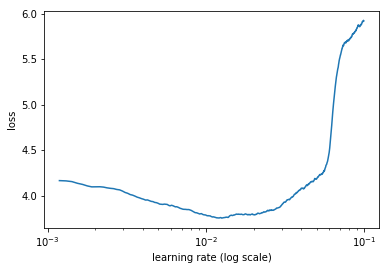

In [56]:
learner.sched.plot()

In [57]:
learner.fit(lr, 1, wds=wd, use_clr=(20,10), cycle_len=8)

epoch      trn_loss   val_loss   accuracy                   
    0      3.299928   3.093423   0.403591  
    1      3.029824   2.92173    0.423345                   
    2      2.859875   2.859685   0.432031                   
    3      2.772596   2.824278   0.43705                    
    4      2.676358   2.808784   0.439752                   
    5      2.631299   2.79837    0.441467                   
    6      2.577469   2.795148   0.442753                   
    7      2.571613   2.791641   0.444109                   



[array([2.79164]), 0.44410886174619857]

We save the trained model weights and separately save the encoder part of the LM model as well. This will serve as our backbone in the classification task model.

In [58]:
learner.save('lm1')

In [59]:
learner.save_encoder('lm1_enc')

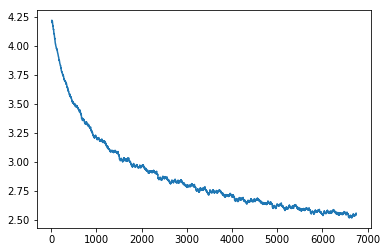

In [60]:
learner.sched.plot_loss()

## Classifier tokens

The classifier model is basically a linear layer custom head on top of the LM backbone. Setting up the classifier data is similar to the LM data setup except that we cannot use the unsup movie reviews this time.

In [61]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'val.csv', header=None, chunksize=chunksize)
df_real_test = pd.read_csv(CLAS_PATH/'real_test.csv', header=None, chunksize=chunksize)

In [62]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)
tok_real_test, real_test_labels = get_all(df_real_test, 1)

0
0
0
1


In [63]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)
np.save(CLAS_PATH/'tmp'/'tok_real_test.npy', tok_real_test)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)
np.save(CLAS_PATH/'tmp'/'real_test_labels.npy', real_test_labels)

In [64]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')
tok_real_test = np.load(CLAS_PATH/'tmp'/'tok_real_test.npy')
print(len(tok_real_test))

27310


In [65]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

17011

In [66]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])
real_test_clas = np.array([[stoi[o] for o in p] for p in tok_real_test])

In [67]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)
np.save(CLAS_PATH/'tmp'/'real_test_ids.npy', real_test_clas)

## Classifier

Now we can create our final model, a classifier which is really a custom linear head over our trained backbone. The steps to create the classifier model are similar to the ones for the LM.

In [68]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')
real_test_clas = np.load(CLAS_PATH/'tmp'/'real_test_ids.npy')

In [69]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))
real_test_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'real_test_labels.npy'))

In [70]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [71]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [72]:
print(val_labels)

[0 3 2 ... 3 1 0]


In the classifier, unlike LM, we need to read a movie review at a time and learn to predict the it's sentiment as pos/neg. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized movie reviews, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.

In [73]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
real_test_ds = TextDataset(real_test_clas, real_test_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
real_test_dl = DataLoader(real_test_ds, bs, transpose=True, num_workers=1, pad_idx=1)
md = ModelData(PATH, trn_dl, val_dl, real_test_dl)

In [74]:
print(len(real_test_clas))
print(len(real_test_ds.x))
print(len(real_test_ds.y))

27310
27310
27310


In [75]:
# part 1
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [76]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [77]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 150, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [78]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [79]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [80]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [81]:
#lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [82]:
wd = 1e-7
#wd = 0
learn.load_encoder('lm1_enc')

In [83]:
learn.freeze_to(-1)

 75%|███████▍  | 680/911 [00:35<00:11, 19.25it/s, loss=3.76] 

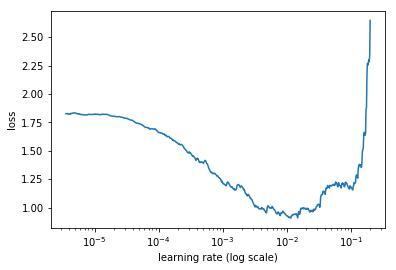

In [84]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [85]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                    
    0      0.534148   0.391781   0.865997  


[array([0.39178]), 0.8659970084278795]

In [86]:
learn.save('clas_0')

In [87]:
learn.load('clas_0')

In [88]:
learn.freeze_to(-2)

In [89]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                    
    0      0.382427   0.264378   0.910973  


[array([0.26438]), 0.9109734349369415]

In [90]:
learn.save('clas_1')

In [91]:
learn.load('clas_1')

In [92]:
learn.unfreeze()

In [93]:
learn.fit(lrs, 1, wds=wd, cycle_len=10, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                    
    0      0.30607    0.241125   0.921502  
    1      0.219587   0.229058   0.925443                    
    2      0.199383   0.188336   0.945056                    
    3      0.093296   0.228415   0.935765                     
    4      0.076242   0.168372   0.955924                     
    5      0.048281   0.153604   0.957843                     
    6      0.039536   0.178632   0.952272                     
    7      0.029311   0.176399   0.963602                     
    8      0.021888   0.173255   0.962547                     
    9      0.012678   0.181976   0.960982                     


[array([0.18198]), 0.960981576562565]

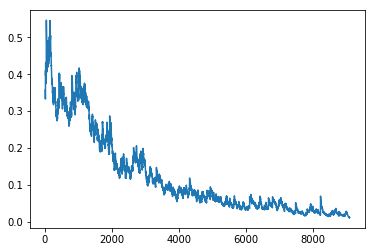

In [94]:
learn.sched.plot_loss()

In [95]:
learn.save('clas_2')

In [96]:
learn.load('clas_2')

In [97]:
costs = np.array([[0,1,2,3,4,6],[1,0,1,4,5,8],[3,2,0,3,5,8],[10,7,5,0,2,7],[20,16,12,4,0,8],[44,38,32,19,13,0]])
names = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']

In [98]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes=['A1', 'A2', 'B1', 'B2', 'C1', 'C2'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [99]:
from sklearn.metrics import confusion_matrix
print_confusion = True
def cost(y_pred, y_true):
    confusion = confusion_matrix(y_true, y_pred)
    res = (1/y_true.shape[0]) * np.sum(np.multiply(costs, confusion))
    res_by_level = np.sum(np.multiply(costs, confusion), axis=1)
    
    if print_confusion:
        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y_true, y_pred)
        np.set_printoptions(precision=2)

        # Plot normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, normalize=False, title='Confusion matrix')
        plt.show()
        plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')
        plt.show()
    return res, res_by_level

[0 3 2 ... 3 1 0]
5462
[2 5 2 ... 0 0 0]
[0 3 2 ... 3 1 0]
[2 5 2 ... 0 0 0]
Confusion matrix, without normalization
[[2314    9    6    0    5    0]
 [  23 1456   13    4    1    0]
 [   3   14 1029    6    0    0]
 [   1    8   18  443    3    0]
 [   1    4   10    8   76    0]
 [   0    0    0    2    0    5]]


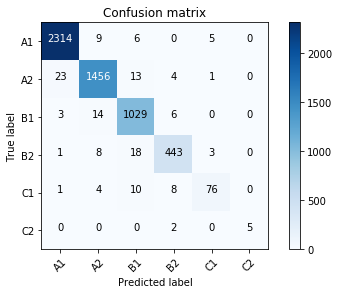

Normalized confusion matrix
[[0.99 0.   0.   0.   0.   0.  ]
 [0.02 0.97 0.01 0.   0.   0.  ]
 [0.   0.01 0.98 0.01 0.   0.  ]
 [0.   0.02 0.04 0.94 0.01 0.  ]
 [0.01 0.04 0.1  0.08 0.77 0.  ]
 [0.   0.   0.   0.29 0.   0.71]]


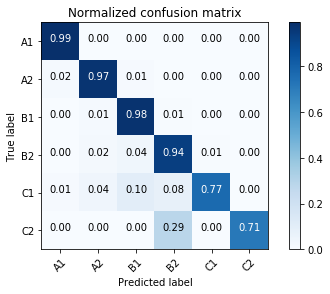

(0.10783595752471621, array([ 41,  57,  55, 162, 236,  38]))


In [100]:
y_pred, y_val2 = learn.predict_with_targs()
#print(y_pred)
y_pred = np.argmax(learn.predict_dl(val_dl), axis=1)
print(val_labels)
print(len(y_pred))
print(y_pred)
print(y_val)
print(y_val2)
print(cost(y_pred, y_val2))

# Submission
Pour l'instant ça prédit le fichier train_Cap.csv (pour vérifier que ça fonctionne).

In [101]:
y_pred = np.argmax(learn.predict_dl(real_test_dl), axis=1)

In [107]:
print(y_pred)
y = np.array(real_test_y.replace({"A1": 0, "A2" : 1, "B1" : 2, "B2" : 3, "C1" : 4, "C2" : 5}))
print(y)

[5 5 5 ... 0 0 0]
[5 5 5 ... 0 0 0]


27310
(27310,)
Confusion matrix, without normalization
[[11344     8     4     1     4     0]
 [   26  7642    15     5     0     0]
 [    4    14  5359     6     0     0]
 [    2     8    22  2303     2     0]
 [    3     3    13     7   465     0]
 [    0     0     1     2     2    45]]


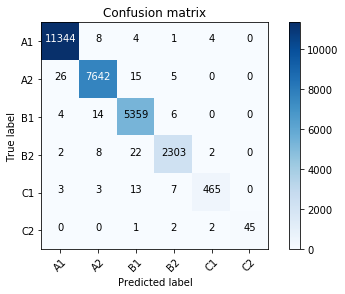

Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.  ]
 [0.   0.99 0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.01 0.99 0.   0.  ]
 [0.01 0.01 0.03 0.01 0.95 0.  ]
 [0.   0.   0.02 0.04 0.04 0.9 ]]


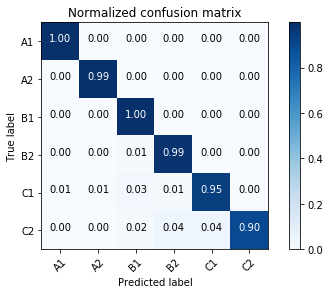

(0.026803368729403147, array([ 35,  61,  58, 190, 292,  96]))


In [108]:
print(len(y_pred))
print(real_test_y.shape)
print(cost(y_pred, y))